In [229]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import h5py
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

1- Load data .mat

In [230]:
dataset_folder = '../data/GPVS-Faults'
filenames = sorted([f for f in os.listdir(dataset_folder) if f.endswith('.mat')])

# class_names like "F0L"
class_names = [fn[:3] for fn in filenames]
le = LabelEncoder()
le.fit(class_names)
print("Classes found:", le.classes_)

Classes found: ['F0L' 'F0M' 'F1L' 'F1M' 'F2L' 'F2M' 'F3L' 'F3M' 'F4L' 'F4M' 'F5L' 'F5M'
 'F6L' 'F6M' 'F7L' 'F7M']


In [231]:
# - This function extracts columns D..Q and the textual column names.
def read_mat_file(path, label=None):
    """
    Read .mat (v7.3 HDF5) style and return pandas DataFrame with columns names extracted.
    If label is provided, add a 'label' column with that string.
    """
    with h5py.File(path, 'r') as f:
        # find the '#refs#' group style used in these MAT files
        if '#refs#' not in f:
            # fallback: try to load numeric dataset heuristically (not expected here)
            raise ValueError("Expected '#refs#' group not found in file")
        refs = f['#refs#']
        # keys 'd'..'q' correspond to the 14 columns in the dataset according to your friend
        keys = [k for k in refs.keys() if ('d' <= k <= 'q')]
        if len(keys) == 0:
            raise ValueError("No expected data keys (d..q) found under '#refs#'")
        # read arrays and ravel to 1D
        data_arrays = [np.array(refs[k]).ravel() for k in keys]
        data = np.vstack(data_arrays).T  # shape (n_samples, n_columns)

        # extract human-readable names from '#refs#/v' (UTF-16)
        names = []
        for ref in refs['v']:
            # each ref is an object reference; pick the first element as the dataset
            obj = f[ref[0]]
            try:
                s = obj[:].tobytes().decode('utf-16', errors='ignore').strip('\x00')
            except Exception:
                # fallback to ascii decode if utf-16 fails
                s = obj[:].tobytes().decode('utf-8', errors='ignore').strip('\x00')
            names.append(s)
        # If number of extracted names > data columns, trim; if fewer, create generic names
        if len(names) >= data.shape[1]:
            colnames = names[:data.shape[1]]
        else:
            # fallback generic names D..Q
            colnames = [f"col_{i}" for i in range(data.shape[1])]
        df = pd.DataFrame(data, columns=colnames)
        if label is not None:
            df["label"] = label
        return df

2- Outlier detection (IQR) and replacement (local mean):
 - Outliers are detected using the IQR rule — robust to skewed distributions. Replacing with the local centered mean preserves local signal trends and avoids introducing abrupt jumps or removing rows (which would break temporal alignment). Using only local mean is simple, stable, and suits sensor noise correction.

In [232]:
def detect_outliers(x, k=1.5):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (x < lower) | (x > upper)

def replace_outliers_local_mean(x, window=11):
    """
    Replace outlier points with centered rolling mean.
    Returns replaced array and boolean mask of outliers.
    """
    x = np.asarray(x, dtype=float).copy()
    mask = detect_outliers(x)
    if not mask.any():
        return x, mask
    wl = int(window)
    if wl < 3: wl = 3
    if wl % 2 == 0: wl += 1
    ser = pd.Series(x)
    roll = ser.rolling(window=wl, center=True, min_periods=1).mean().values
    x[mask] = roll[mask]
    return x, mask

4- Z-score normalization:
- Z-score standardizes each channel to zero mean and unit variance. This is important because different sensors have different units and scales; standardization helps PCA and downstream models converge and treat channels fairly.

In [233]:
def zscore_series(x, eps=1e-8):
    x = np.asarray(x, dtype=float)
    mu = x.mean()
    sigma = x.std()
    if sigma < eps:
        return x - mu
    return (x - mu) / sigma

def zscore_dataframe(df, cols):
    out = df.copy()
    for c in cols:
        out[c] = zscore_series(out[c].values)
    return out

5- Sliding-window segmentation (window length in samples, 50% overlap default):
- This converts a long multivariate timeseries into many fixed-length segments for LSTM input. 50% overlap increases sample count and smooths transitions between adjacent windows.

In [234]:
def sliding_windows(arr, window_len, stride=None):
    arr = np.asarray(arr)
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    n = arr.shape[0]
    if stride is None:
        stride = max(1, window_len // 2)
    if window_len > n:
        return np.empty((0, window_len, arr.shape[1]))
    starts = np.arange(0, n - window_len + 1, stride)
    windows = np.stack([arr[s:s+window_len] for s in starts], axis=0)
    return windows

6- PCA dimensionality reduction across channels (per timestep):
- PCA reduces the number of channels per timestep, keeping most variance while decreasing model input size and redundancy. The function auto-limits components to what is mathematically possible.

In [235]:
def apply_pca_safe(X, n_components_requested=4):
    X = np.asarray(X)
    n_samples, n_features = X.shape
    max_comp = min(n_samples, n_features)
    n_comp = max(1, min(int(n_components_requested), max_comp))
    if max_comp <= 1:
        # nothing to reduce meaningfully
        return X.reshape(n_samples, 1), None, 1
    pca = PCA(n_components=n_comp)
    Xp = pca.fit_transform(X)
    return Xp, pca, n_comp

7- Full per-file pipeline function (uses previous building blocks):
- This function processes one file end-to-end: outlier correction (local mean), normalization, PCA, and segmentation. It returns windows ready for LSTM and metadata useful for debugging.

In [236]:
from scipy.interpolate import interp1d  # ensure interp1d is available

def process_file_df(df, sensor_cols, outlier_window=11,
                    do_zscore=True, pca_components=4, window_len=128, stride=None):
    """
    Returns dict including:
      - df_raw (original), df_after_outlier, df_after_zscore, pca_obj, pca_transformed, windows
    """
    available = [c for c in sensor_cols if c in df.columns]
    if len(available) == 0:
        raise ValueError("No sensor columns available in df")
    df_raw = df[available].copy().reset_index(drop=True)

    # 1) outlier replacement (local mean)
    df_after_outlier = df_raw.copy()
    outlier_masks = {}
    for c in available:
        replaced, mask = replace_outliers_local_mean(df_after_outlier[c].values, window=outlier_window)
        df_after_outlier[c] = replaced
        outlier_masks[c] = mask

    # 2) z-score
    df_after_zscore = df_after_outlier.copy()
    if do_zscore:
        df_after_zscore = zscore_dataframe(df_after_zscore, available)

    # 3) PCA across channels
    X = df_after_zscore.values
    Xp, pca_obj, n_comp_used = apply_pca_safe(X, n_components_requested=pca_components)

    # 4) sliding windows on PCA output
    windows = sliding_windows(Xp, window_len=window_len, stride=stride)

    return {
        "available_cols": available,
        "df_raw": df_raw,
        "df_after_outlier": df_after_outlier,
        "outlier_masks": outlier_masks,
        "df_after_zscore": df_after_zscore,
        "pca": pca_obj,
        "pca_transformed": Xp,
        "n_comp_used": n_comp_used,
        "windows": windows
    }

8- Loop over all files, build dataset and labels
- This iterates all files, processes each into windows, collects windows and integer labels. meta stores per-file info (useful to inspect files that produced few/no windows or used few PCA components).

In [237]:
sensor_columns = ["Time","Ipv","Vpv","Vdc","ia","ib","ic","va","vb","vc","Iabc","If","Vabc","Vf"]  # expected order
# Note: we usually exclude 'Time' from sensors passed to models; handle below.

OUTLIER_METHOD = 'local_mean'
OUTLIER_WINDOW = 11
DO_ZSCORE = True
PCA_COMPONENTS = 4
WINDOW_LEN = 128
STRIDE = WINDOW_LEN // 2

all_windows_list = []
all_labels = []
meta = []

for fn in tqdm(filenames, desc="Processing files"):
    path = os.path.join(dataset_folder, fn)
    label_str = fn[:3]  # e.g., F0L
    try:
        df = read_mat_file(path, label=label_str)
    except Exception as e:
        print(f"Skipping {fn}: {e}")
        continue

    # drop Time column for sensors if present (Time is not a sensor channel)
    sensors = [c for c in sensor_columns if c in df.columns and c != 'Time']
    if len(sensors) == 0:
        print(f"Skipping {fn}: no sensor columns found")
        continue

    res = process_file_df(
        df,
        sensor_cols = sensors,
        outlier_window = OUTLIER_WINDOW,
        do_zscore = DO_ZSCORE,
        pca_components = PCA_COMPONENTS,
        window_len = WINDOW_LEN,
        stride = STRIDE
    )

    w = res["windows"]
    if w.shape[0] == 0:
        meta.append({"file": fn, "n_windows": 0, "n_comp_used": res["n_comp_used"], "cols": res["available_cols"]})
        continue

    all_windows_list.append(w)
    # label each window with encoded integer label
    lbl = le.transform([label_str])[0]
    all_labels.extend([lbl] * w.shape[0])
    meta.append({"file": fn, "n_windows": w.shape[0], "n_comp_used": res["n_comp_used"], "cols": res["available_cols"]})

# Concatenate
if all_windows_list:
    all_windows = np.concatenate(all_windows_list, axis=0)   # shape (total_windows, window_len, n_components)
    all_labels = np.array(all_labels, dtype=int)
else:
    all_windows = np.empty((0, WINDOW_LEN, PCA_COMPONENTS))
    all_labels = np.empty((0,), dtype=int)

print("Total windows:", all_windows.shape)
print("Labels shape:", all_labels.shape)

Processing files: 100%|██████████| 16/16 [00:01<00:00, 10.36it/s]

Total windows: (33783, 128, 4)
Labels shape: (33783,)


In [238]:
#print("Example meta entries (first 10):")
#for m in meta[:10]:
#    print(m)

#if all_windows.shape[0] > 0:
#    print("Sample window shape:", all_windows[0].shape)
#    print("Example labels (first 20):", all_labels[:20])

# If you want to inspect PCA explained variance for the first processed file:
# find first file with PCA object in meta
#for fn in filenames:
#    try:
#        df = read_mat_file(os.path.join(dataset_folder, fn), label=None)
#        sensors = [c for c in sensor_columns if c in df.columns and c != 'Time']
#        res = process_file_df(df, sensor_cols=sensors, do_zscore=DO_ZSCORE, pca_components=PCA_COMPONENTS, window_len=WINDOW_LEN)
#        if res['pca'] is not None:
#            print(f"PCA components used: {res['n_comp_used']}")
#            print("Explained variance ratio:", res['pca'].explained_variance_ratio_)
#            break
#    except Exception:
#        continue

10- Ploting


=== Diagnostics for F0L.mat ===
Representative sensor used for plots: Ipv


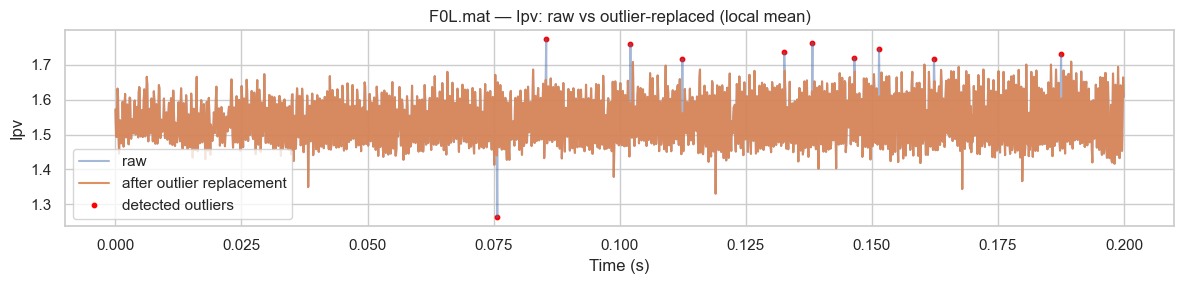

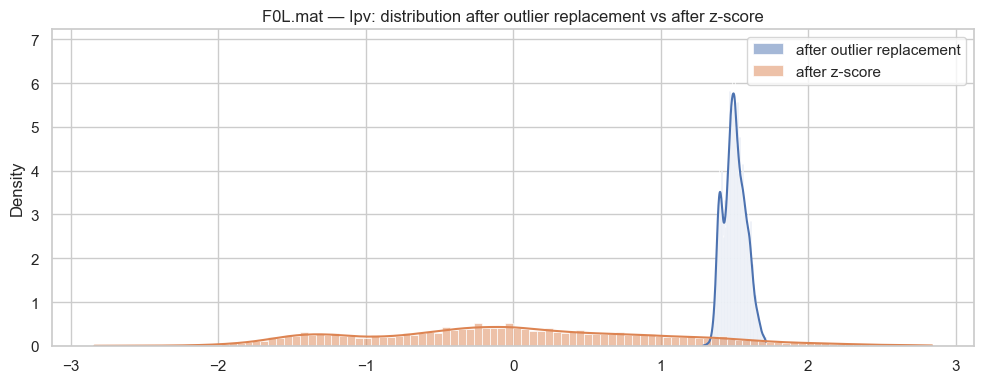

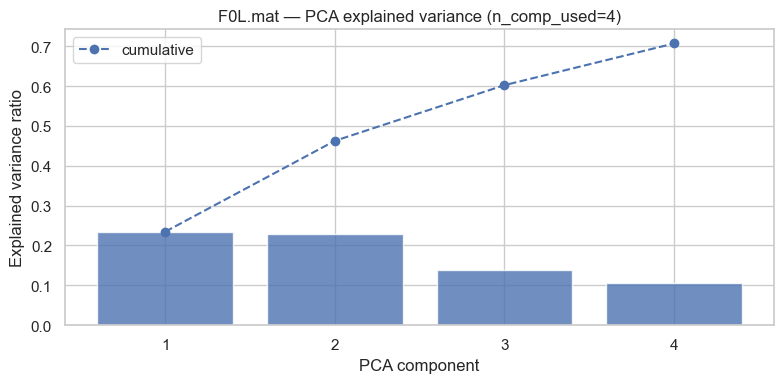

In [239]:
sns.set(style="whitegrid", rc={"figure.figsize": (10,4)})

# --- configure which files to plot (default: first file only) ---
PLOT_FILES = filenames[:1]   # change to filenames[:n] if you want n files

# Loop over files (processing done already earlier in pipeline)
for fn in PLOT_FILES:
    path = os.path.join(dataset_folder, fn)
    print(f"\n=== Diagnostics for {fn} ===")
    try:
        df = read_mat_file(path, label=None)
    except Exception as e:
        print("Cannot read file:", e)
        continue

    # choose sensors (exclude Time) and pick one representative sensor for detailed plots
    sensors = [c for c in ["Ipv","Vpv","Vdc","ia","ib","ic","va","vb","vc","Iabc","If","Vabc","Vf"] if c in df.columns]
    if len(sensors) == 0:
        print("No sensor columns found, skipping", fn)
        continue

    rep_sensor = sensors[0]   # representative sensor used for plots (first available)
    print("Representative sensor used for plots:", rep_sensor)

    # ---- 1) Outlier replacement (local mean) ----
    # Use same function as pipeline: replace_outliers_local_mean
    raw_series = df[rep_sensor].values.astype(float)
    replaced_series, mask = replace_outliers_local_mean(raw_series, window=OUTLIER_WINDOW)

    # Prepare df_after_outlier and df_after_zscore for this file & sensors
    df_after_outlier = df[sensors].copy().reset_index(drop=True)
    for c in sensors:
        arr, _ = replace_outliers_local_mean(df_after_outlier[c].values, window=OUTLIER_WINDOW)
        df_after_outlier[c] = arr

    df_after_zscore = df_after_outlier.copy()
    if DO_ZSCORE:
        df_after_zscore = zscore_dataframe(df_after_zscore, sensors)

    # ---- Plot 1: raw vs after outlier replacement (line) ----
    # Explanation: shows spike removal and preservation of waveform.
    plt.figure(figsize=(12,3))
    if "Time" in df.columns:
        t = df["Time"].values
        # limit number of plotted samples for speed/clarity
        N = min(2000, len(t))
        plt.plot(t[:N], raw_series[:N], label="raw", alpha=0.5)
        plt.plot(t[:N], replaced_series[:N], label="after outlier replacement", alpha=0.9)
        if mask[:N].any():
            plt.scatter(t[:N][mask[:N]], raw_series[:N][mask[:N]], color='red', s=10, label="detected outliers")
        plt.xlabel("Time (s)")
    else:
        N = min(2000, len(raw_series))
        idx = np.arange(N)
        plt.plot(idx, raw_series[:N], label="raw", alpha=0.5)
        plt.plot(idx, replaced_series[:N], label="after outlier replacement", alpha=0.9)
        if mask[:N].any():
            plt.scatter(idx[mask[:N]], raw_series[:N][mask[:N]], color='red', s=10, label="detected outliers")
        plt.xlabel("Samples")
    plt.ylabel(rep_sensor)
    plt.title(f"{fn} — {rep_sensor}: raw vs outlier-replaced (local mean)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- Plot 2: distribution after outlier replacement vs after z-score ----
    # Explanation: shows how z-score centers and rescales the distribution
    plt.figure(figsize=(10,4))
    sns.histplot(df_after_outlier[rep_sensor].dropna().values, stat="density", label="after outlier replacement", kde=True, alpha=0.5)
    sns.histplot(df_after_zscore[rep_sensor].dropna().values, stat="density", label="after z-score", kde=True, alpha=0.5)
    plt.title(f"{fn} — {rep_sensor}: distribution after outlier replacement vs after z-score")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- Plot 3: PCA explained variance across sensors ----
    # Prepare PCA input using df_after_zscore for all sensors
    X = df_after_zscore[sensors].values
    Xp, pca_obj, n_comp_used = apply_pca_safe(X, n_components_requested=PCA_COMPONENTS)
    if pca_obj is not None:
        ratios = pca_obj.explained_variance_ratio_
        comp_idx = np.arange(1, len(ratios) + 1)
        plt.figure(figsize=(8,4))
        plt.bar(comp_idx, ratios, alpha=0.8)
        plt.plot(comp_idx, np.cumsum(ratios), marker='o', linestyle='--', label='cumulative')
        plt.xlabel("PCA component")
        plt.ylabel("Explained variance ratio")
        plt.title(f"{fn} — PCA explained variance (n_comp_used={n_comp_used})")
        plt.xticks(comp_idx)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("PCA not applicable (not enough dimensions) for", fn)

# end for PLOT_FILES

- Raw vs outlier-replaced line plot: immediately verifies that spikes/outliers are detected and replaced by a smooth local mean; you see whether the replacement introduces artifacts.

- Distribution comparison: confirms z-score did its job (centering to ~0 and scaling to unit variance) and shows the change in tails after outlier correction.

- PCA explained variance: indicates the amount of variance captured by each component; helps you choose how many PCA components to keep for LSTM input.